# Vector Reflectivity Equation Comparison

This notebook compares the forward and adjoint operators of different forms of the vector reflectivity based acoustic wave equation.

In [1]:
import numpy as np
from devito import *
from examples.seismic import setup_geometry, demo_model, RickerSource, Receiver, plot_velocity,\
    plot_shotrecord, ModelViscoacoustic, TimeAxis
from examples.seismic.preset_models import Gardners

from examples.seismic.vector_reflectivity.model_creators import model_layer, model_marmousi


# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sympy import latex
from IPython.display import Latex

mpi4py is not available. You must install it


In [2]:
def RMS(data):
    n = np.size(data)
    return (np.sum(data**2)/n)**0.5

## Source and receivers creators


In [3]:
# Function to create sources and receivers
def src_rec(model, geometry, src_pos, rec_depth, nrec):
    src = RickerSource(name='src', grid=model.grid, f0=geometry.f0, 
                       time_range=geometry.time_axis, npoint=1)

    rec = Receiver(name='rec', grid=model.grid, npoint=nrec,
                   time_range=geometry.time_axis)

    src.coordinates.data[:, 0] = src_pos[0]
    src.coordinates.data[:, 1] = src_pos[1]
    rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nrec)
    rec.coordinates.data[:, 1] = rec_depth
    
    return src, rec


# Function to create adjoint sources
def adjoint_src(model, geometry, src_pos):
    srca = Receiver(name='srca', grid=model.grid,
                    time_range=geometry.time_axis,
                    npoint=1)

    srca.coordinates.data[:, 0] = src_pos[0]
    srca.coordinates.data[:, 1] = src_pos[1]

    return srca

def adjoint_line_src(model, geometry, src_depth, nsrc):
    srca = Receiver(name='srca', grid=model.grid,
                    time_range=geometry.time_axis,
                    npoint=nsrc)

    srca.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nsrc)
    srca.coordinates.data[:, 1] = src_depth

    return srca

## Acquisition geometry and model

In [4]:
# Parameters

# NX = 101
# NZ = 101

# SHAPE = (NX, NZ)
# ORIGIN = (0, 0)
# SPACING = (5, 5)
# NLAYERS = 2
# SPACE_ORDER = 2
TIME_ORDER = 2
# DTYPE = np.float64
# NBL = 50

In [5]:
def gen_vp(vp_list: list, shape, dtype = np.float64):
    vp = np.ones(shape, dtype)
    nlayers = len(vp_list)
    
    for i, vpi in enumerate(vp_list):
        idx_top = i*shape[1]//nlayers
        idx_bottom = (i+1)*shape[1]//nlayers
        vp[:, idx_top : idx_bottom] *= vpi
    
    return vp

In [6]:
def load_marmousi(path):
    vp = np.fromfile(path, dtype=np.float32)/1000
    vp = vp.astype(np.float64)

    nx = 738
    nz = 240
    dx = 12.5
    dz = 12.5
    nbl = 40

    shape = (nx, nz)
    spacing = (dx, dz)
    origin = (0, 0)

    vp = vp.reshape(shape)
    # b = Gardners(vp)
    b = np.ones_like(vp)
    
    space_order = 16

    model = ModelViscoacoustic(vp=vp, b=b, origin=origin, spacing=spacing, shape=shape, 
    # model = ModelViscoacoustic(vp=vp, origin=origin, spacing=spacing, shape=shape, 
                               space_order=space_order, nbl=nbl, bcs='damp', staggered=NODE,
                               dtype=np.float64)
    
    return model


In [7]:
# model = demo_model(preset, **preset_params[preset])

# vp1 = 1.5
# vp2 = 3.5
# vp_list = [1.5, 2.0, 3.5, 4.0, 6.0]
# vp_list = [1.5, 2.0, 3.5, 4.0, 3.0, 6.0, 7.0, 7.5, 8.0]
# vp = gen_vp(vp_list, SHAPE, DTYPE)

# vp = np.ones(SHAPE, dtype=DTYPE)
# vp *= vp1
# vp[:,SHAPE[1]//2:] = vp2

# b = Gardners(vp, normalize=True)
# rho = 0.31*(vp[:]*1000.)**0.25
# b = 1/rho
# b = 1.5*np.ones_like(vp)

# model = ModelViscoacoustic(
#      vp=vp, b=b, origin=ORIGIN, spacing=SPACING, shape=SHAPE, space_order=model.space_order, 
#      nbl=NBL, bcs='damp', dtype=DTYPE, staggered=NODE
# )

In [8]:
vp_list0 = [1.5]
vp_list1 = [1.5, 2.0]
vp_list2 = [1.5, 2.5, 3.5, 4.0, 5.0]
vp_list3 = [1.5, 2.0, 3.5, 2.1, 3.6, 4.0, 2.1, 3.7, 5.8, 6.0]

model = model_layer(vp_list0, np.float64)
# model = load_marmousi('/home/filipe/projects/models/marmousi-resample/marmousi-resample-738x240.bin')

Operator `initdamp` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


In [9]:
# function to plot P wave velocit, and the x and z components of R
def img_model(img1, img2, img3, model):

    plt_options_model = {'cmap': 'jet', 'extent': [model.origin[0],
                         model.origin[0] + model.domain_size[0],
                         model.origin[1] + model.domain_size[1],
                         model.origin[1]]}

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))

    scale1 = np.max(img1)
    scale2 = np.min(img1)

    imag1 = ax[0].imshow(np.transpose(img1), vmin=scale1, vmax=scale2,
                         **plt_options_model)
    fig.colorbar(imag1, ax=ax[0])
    ax[0].set_title("$v_P$ (km/s)", fontsize=20)
    ax[0].set_xlabel('z (m)', fontsize=20)
    ax[0].set_ylabel('x (m)', fontsize=20)
    ax[0].set_aspect('auto')

    scale3 = np.max(img2)
    scale4 = np.min(img2)

    plt_options_model.update({'cmap': 'Greys'})

    imag2 = ax[1].imshow(np.transpose(img2), vmin=scale3, vmax=scale4,
                         **plt_options_model)
    fig.colorbar(imag2, ax=ax[1])
    ax[1].set_title(r"$\mathbf{R}$ (Horizontal component)", fontsize=20)
    ax[1].set_xlabel('z (m)', fontsize=20)
    ax[1].set_ylabel('x (m)', fontsize=20)
    ax[1].set_aspect('auto')

    scale5 = np.max(img3)
    scale6 = np.min(img3)

    imag3 = ax[2].imshow(np.transpose(img3), vmin=scale5, vmax=scale6,
                         **plt_options_model)
    fig.colorbar(imag3, ax=ax[2])
    ax[2].set_title(r"$\mathbf{R}$ (Vertical component)", fontsize=20)
    ax[2].set_xlabel('z (m)', fontsize=20)
    ax[2].set_ylabel('x (m)', fontsize=20)
    ax[2].set_aspect('auto')

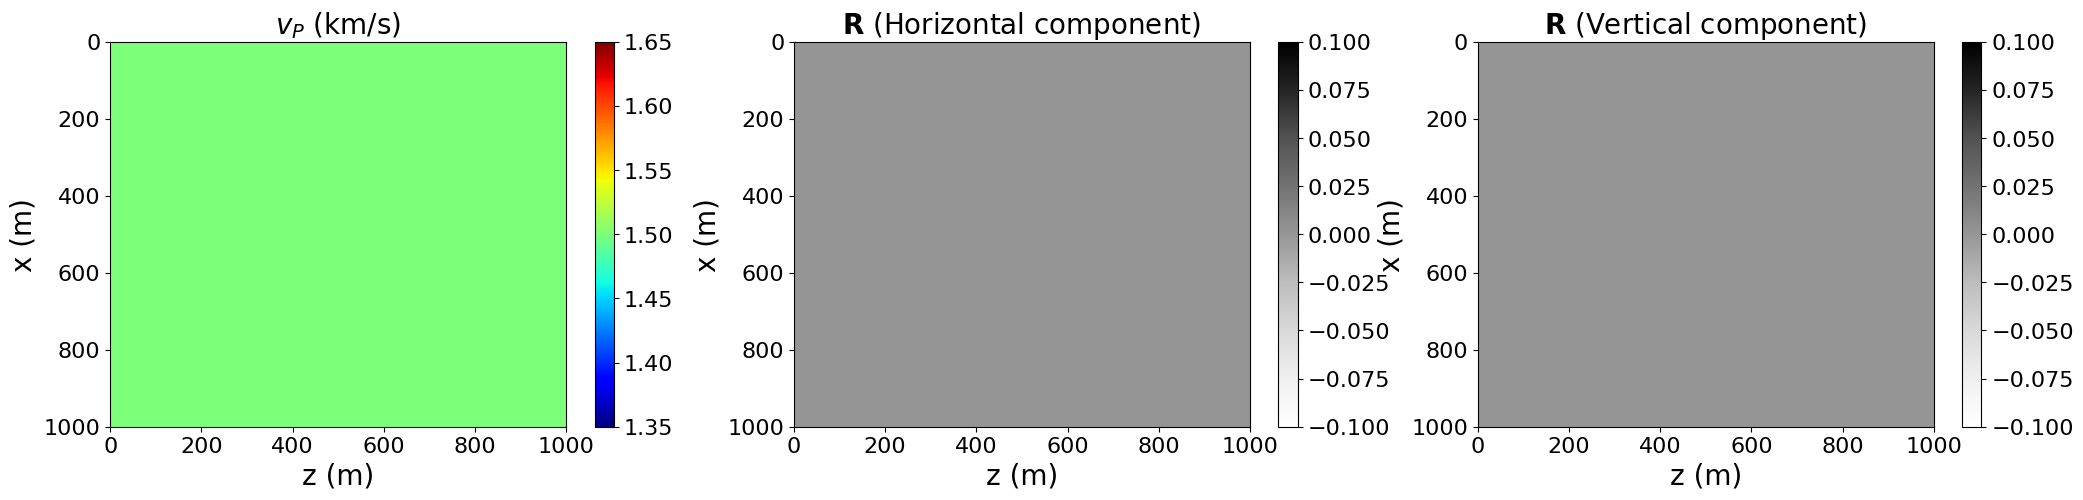

In [10]:
img_model(
    model.vp.data[model.nbl:-model.nbl, model.nbl:-model.nbl], 
    model.r[0].data[model.nbl:-model.nbl, model.nbl:-model.nbl], 
    model.r[1].data[model.nbl:-model.nbl, model.nbl:-model.nbl], 
    model
)

In [ ]:
# tn = 1000
tn = 400
f0 = 0.030
# max_dt = (np.max(model.vp.data * 1e3)*(1/SPACING[0]**2 + 1/SPACING[1]**2 - np.min(divr.data)/2)**.5)**-1
# dt = 0.9*max_dt
dt = model.critical_dt

geometry = setup_geometry(model, tn, f0)
geometry.resample(dt)

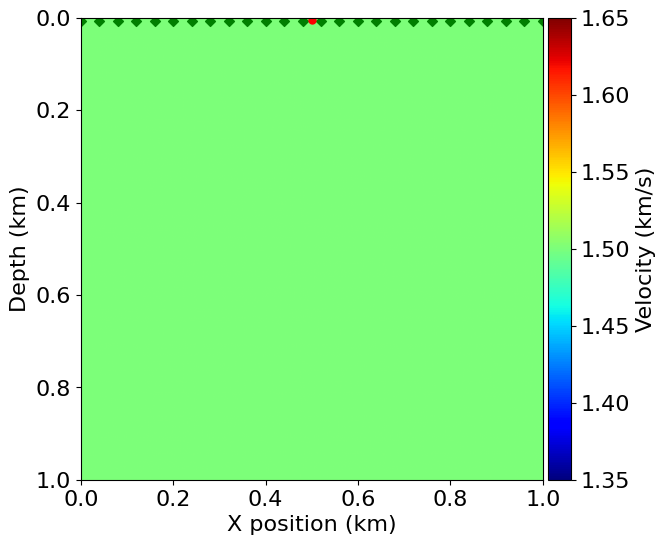

In [12]:
plot_velocity(model, geometry.src_positions, geometry.rec_positions[::10])

## Operators

In [13]:
class OpWrapper():
    def __init__(self, forward, adjoint):
        self.forward = forward
        self.adjoint = adjoint

    def __call__(self, model, geometry, src, rec, **kwargs):
        return self.forward(model, geometry, src, rec, **kwargs)
    
    def T(self, model, geometry, rec, srca=None, **kwargs):
        return self.adjoint(model, geometry, rec, srca, **kwargs)

### Original

The original equation presented in the paper by [Whitmore et al. (2020)](https://doi.org/10.1190/segam2020-3424516.1), but multiplied by $m = \dfrac{1}{v_p^2}$


$$
\begin{aligned}
\mathbf{R} &= \frac{1}{2} \frac{\nabla (v_p \rho)}{v_p \rho}\\
    &= \frac{1}{2}\left( \frac{\nabla v_p}{v_p} + \frac{\nabla \rho}{\rho} \right)\\
    &= \frac{1}{2}\left( \frac{\nabla v_p}{v_p} - \frac{\nabla b}{b} \right)
\end{aligned}
$$

- Forward:

    $$
        m\frac{\partial^2 u}{\partial t^2} - \left[ \nabla^2u + \frac{1}{v_p}\nabla v_p \cdot \nabla u - 2 \mathbf{R} \cdot \nabla u \right] = S
    $$
    
    $$
        m\frac{\partial^2 u}{\partial t^2} - \nabla^2u + \left(-\frac{1}{v_p}\nabla v_p + 2 \mathbf{R}\right) \cdot \nabla u = S
    $$

- Backward:

    $$
        m\frac{\partial^2 v}{\partial t^2} - \left[ \nabla^2v + \nabla \cdot \left(\frac{1}{v_p}(\nabla v_p) v\right) - 2  \nabla \cdot \mathbf{R} v \right] = R
    $$
    $$
        m\frac{\partial^2 v}{\partial t^2} - \nabla^2v - \nabla \cdot \left[\left(-\frac{1}{v_p}\nabla v_p + 2 \mathbf{R}\right) v\right] = R
    $$

In [14]:
def forward(model, geometry, src, rec, save=None):
    u = TimeFunction(name='u', grid=model.grid, time_order=TIME_ORDER,
                            space_order=model.space_order, staggered=NODE, 
                            save=save)

    m = model.m
    r = model.r
    vp = model.vp
    dt = model.grid.stepping_dim.spacing

    pde = m * u.dt2 - u.laplace + (- 1/vp*grad(vp) + 2*r).T * grad(u) + model.damp * u.dt
    

    stencil = [Eq(u.forward, solve(pde, u.forward))]

    src_term = src.inject(field=u.forward, expr=src * dt**2/model.m)
    rec_term = rec.interpolate(expr=u)

    op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
    op(dt=geometry.dt)
    
    return u


def adjoint(model: ModelViscoacoustic, geometry, rec, srca=None, save=None):
    v = TimeFunction(name='v', grid=model.grid, time_order=TIME_ORDER,
                    space_order=model.space_order, staggered=NODE,
                    save=save)
    m = model.m
    vp = model.vp
    r = model.r
    dt = model.grid.stepping_dim.spacing

    pde = m * v.dt2 - v.laplace - div((-grad(vp)/vp + 2*r) * v, .5) + model.damp * v.dt.T
    
    stencil = [Eq(v.backward, solve(pde, v.backward))]

    rec_term = rec.inject(v.backward, expr = rec * dt**2 / m)
    # rec_term = rec.inject(v.backward, expr = rec)
    terms = stencil
    terms += rec_term

    if srca:
        srca_term = srca.interpolate(expr=v)
        terms += srca_term

    op = Operator(terms, subs=model.spacing_map)
    op(dt=geometry.dt)
    return v

L_original = OpWrapper(forward, adjoint)

### Acoustic with constant density

The classical acoustic wave equation.

- Forward and backward:

    $$
        m\frac{\partial^2 u}{\partial t^2} - \nabla^2u = S
    $$

In [15]:
def forward(model, geometry, src, rec):
    u = TimeFunction(name='u', grid=model.grid, time_order=TIME_ORDER,
                            space_order=model.space_order)

    m = model.m
    dt = model.grid.stepping_dim.spacing

    pde = m * u.dt2 - u.laplace + model.damp * u.dt
    stencil = [Eq(u.forward, solve(pde, u.forward))]

    src_term = src.inject(field=u.forward, expr=src * dt**2/model.m)
    rec_term = rec.interpolate(expr=u)

    op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
    op(dt=geometry.dt)
    
    return u


def adjoint(model, geometry, rec, srca=None):
    v = TimeFunction(name='v', grid=model.grid, time_order=TIME_ORDER,
                    space_order=model.space_order)
    
    m = model.m
    dt = model.grid.stepping_dim.spacing

    pde = m * v.dt2 - v.laplace + model.damp * v.dt.T
    stencil = [Eq(v.backward, solve(pde, v.backward))]

    rec_term = rec.inject(v.backward, expr = rec * dt**2 / m)

    terms = stencil
    terms += rec_term

    if srca:
        srca_term = srca.interpolate(expr=v)
        terms += srca_term

    op = Operator(terms, subs=model.spacing_map)
    op(dt=geometry.dt)
    return v

# L_acoustic = OpWrapper(forward, adjoint)

### Acoustic with variable density

The classical acoustic wave equation with variable density $\rho$.

- Forward:

    $$
        m\frac{\partial^2 u}{\partial t^2} - \rho \nabla \cdot \left(\frac{1}{\rho} \nabla u\right) = S
    $$
    or
    $$
        m\frac{\partial^2 u}{\partial t^2} - \frac{1}{b} \nabla \cdot \left(b \nabla u\right) = S
    $$
    where $b = \dfrac{1}{\rho}$

- Backward:

    $$
        m\frac{\partial^2 v}{\partial t^2} - \nabla \cdot \left[b \nabla \left( \frac{v}{b} \right)\right] = R
    $$


In [16]:
def forward(model, geometry, src, rec, save=None):
    u = TimeFunction(name='u', grid=model.grid, time_order=TIME_ORDER,
                            space_order=model.space_order, staggered=NODE,
                            save=save)

    rho = 1/model.b
    b = model.b
    m = model.m
    dt = model.grid.stepping_dim.spacing

    pde = m*u.dt2 - rho * div(b * grad(u, .5), -.5) + model.damp * u.dt
    stencil = [Eq(u.forward, solve(pde, u.forward))]

    src_term = src.inject(field=u.forward, expr=src * dt**2/model.m)
    rec_term = rec.interpolate(expr=u)

    op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
    op(dt=geometry.dt)
    
    return u


def adjoint(model, geometry, rec, srca=None, save=None):
    v = TimeFunction(name='v', grid=model.grid, time_order=TIME_ORDER,
                    space_order=model.space_order, staggered=NODE,
                    save=save)
    
    rho = 1/model.b
    b = model.b
    m = model.m
    dt = model.grid.stepping_dim.spacing

    pde = m*v.dt2 - div(b * grad(rho * v, .5), -.5) + model.damp * v.dt.T
    stencil = [Eq(v.backward, solve(pde, v.backward))]

    rec_term = rec.inject(v.backward, expr = rec * dt**2 / m)

    terms = stencil
    terms += rec_term

    if srca:
        srca_term = srca.interpolate(expr=v)
        terms += srca_term

    op = Operator(terms, subs=model.spacing_map)
    op(dt=geometry.dt)
    return v

L_acoustic = OpWrapper(forward, adjoint)

## Comparison

### Seismic data computation

In [17]:
src_pos = geometry.src_positions[0]
rec_depth = geometry.rec_positions[0][1]
nrec = geometry.nrec

src_pos2 = 0.5 * np.array(model.domain_size, dtype = model.dtype)
rec_depth2 = 0.25*model.domain_size[1]
nrec2 = 1

In [18]:
print(src_pos2, rec_depth2, nrec2)

[500. 500.] 250.0 1


In [19]:
# src_modified, rec_modified = src_rec(RMS_Tmodel, geometry, src_pos, rec_depth, nrec)
# srca_modified = adjoint_src(model, geometry, src_pos)

# u_modified = L_modified(model, geometry, src_modified, rec_modified)
# v_modified = L_modified.T(model, geometry, rec_modified, srca_modified)

In [20]:
src_original, rec_original = src_rec(model, geometry, src_pos, rec_depth, nrec)
srca_original = adjoint_src(model, geometry, src_pos)
line_srca_original = adjoint_line_src(model, geometry, rec_depth, nrec)

u_original = L_original(model, geometry, src_original, rec_original)
v_original = L_original.T(model, geometry, rec_original, srca_original)
_ = L_original.T(model, geometry, rec_original, line_srca_original)

Operator `Kernel` ran in 0.12 s
Operator `Kernel` ran in 0.24 s
Operator `Kernel` ran in 0.25 s


In [21]:
src2_original, rec2_original = src_rec(model, geometry, src_pos2, rec_depth2, nrec2)
rec2_original.coordinates.data[0, 0] = model.domain_size[0]/2
# srca_original = adjoint_src(model, geometry, src_pos)
# line_srca_original = adjoint_line_src(model, geometry, rec_depth*0.9, nrec)


u_original = L_original(model, geometry, src2_original, rec2_original, save=geometry.nt)
# rec2_original.data[:] = np.flip(src2_original.data[:], axis=0)
v_original = L_original.T(model, geometry, rec2_original, save=geometry.nt)
# _ = L_original.T(model, geometry, rec_original, line_srca_original)

Operator `Kernel` ran in 0.13 s
Operator `Kernel` ran in 0.23 s


In [22]:
src_acoustic, rec_acoustic = src_rec(model, geometry, src_pos, rec_depth, nrec)
srca_acoustic = adjoint_src(model, geometry, src_pos)
line_srca_acoustic = adjoint_line_src(model, geometry, rec_depth, nrec)

u_acoustic = L_acoustic(model, geometry, src_acoustic, rec_acoustic)
v_acoustic = L_acoustic.T(model, geometry, rec_acoustic, srca_acoustic)
_ = L_acoustic.T(model, geometry, rec_acoustic, line_srca_acoustic)

Operator `Kernel` ran in 0.16 s
Operator `Kernel` ran in 0.33 s
Operator `Kernel` ran in 0.31 s


In [23]:
src2_acoustic, rec2_acoustic = src_rec(model, geometry, src_pos2, rec_depth2, nrec2)
rec2_acoustic.coordinates.data[0, 0] = model.domain_size[0]/2
# srca_original = adjoint_src(model, geometry, src_pos)
# line_srca_original = adjoint_line_src(model, geometry, rec_depth*0.9, nrec)

u_acoustic = L_acoustic(model, geometry, src2_acoustic, rec2_acoustic, save=geometry.nt)
v_acoustic = L_acoustic.T(model, geometry, rec2_acoustic, save=geometry.nt)

Operator `Kernel` ran in 0.12 s
Operator `Kernel` ran in 0.26 s


In [24]:
# src2_original.data[:] = np.flip(src2_original.data[:], axis=0)

In [25]:
type(src2_original), type(rec2_original)

(RickerSource, PointSource)

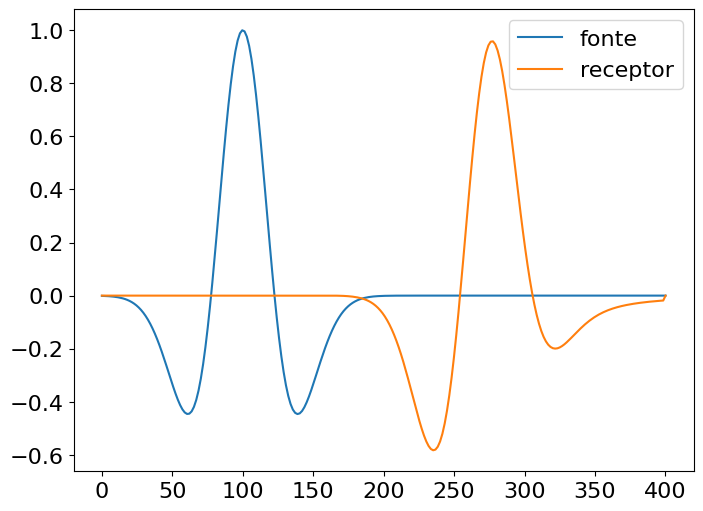

In [26]:

plt.plot(
    geometry.time_axis.time_values, src2_original.data, label='fonte'
)
plt.plot(
    geometry.time_axis.time_values, rec2_original.data, label='receptor'
)
plt.legend()

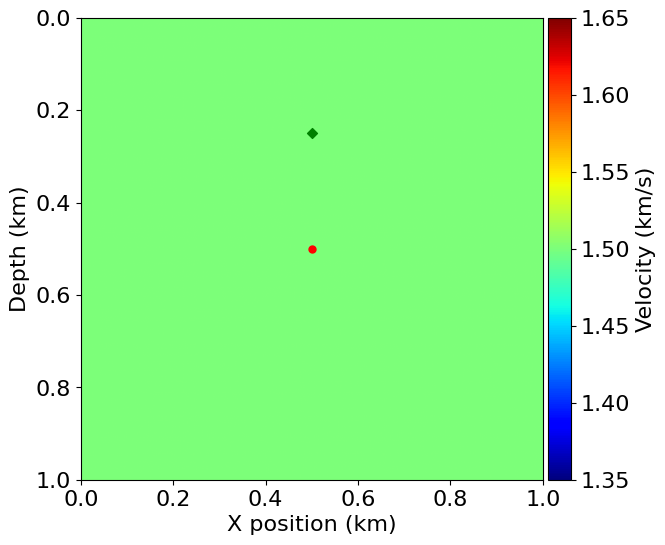

In [27]:
plot_velocity(model, src2_original.coordinates.data, rec2_original.coordinates.data)

### Plotting data

In [28]:
def plot_data(recs, names, model, t0, tn, colorbar=True):
    fig, axes = plt.subplots(1, len(recs), figsize=(8*len(recs), 8))

    for i, rec in enumerate(recs):
        ax = (len(recs) > 1) and axes[i] or axes

        # scale = np.max(rec) / 10.
        scale = np.max(rec)
        extent = [model.origin[0], model.origin[0] + 1e-3*model.domain_size[0],
                1e-3*tn, t0]
        # extent = [model.origin[0], model.origin[0] + model.domain_size[0],
        #         tn, t0]

        plot = ax.imshow(rec, vmin=-scale, vmax=scale, cmap=cm.gray, extent=extent)
        ax.set_title(names[i], fontsize=20)
        ax.set_xlabel('X position (m)', fontsize=20)
        if i == 0:
            ax.set_ylabel('Time (s)', fontsize=20)

        # Create aligned colorbar on the right
        # if colorbar and i == len(recs) - 1:
        if colorbar:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(plot, cax=cax)

    plt.tight_layout()
    plt.show()

In [29]:
# rec_acoustic.data.T.tofile('seismograms/forward_classic.bin')
# rec_original.data.T.tofile('seismograms/forward_vector_reflectivity.bin')
# (rec_acoustic.data - rec_original.data).T.tofile('seismograms/forward_diff.bin')
# line_srca_acoustic.data.T.tofile('seismograms/backward_classic.bin')
# line_srca_original.data.T.tofile('seismograms/backward_vector_reflectivity.bin')
# (line_srca_acoustic.data - line_srca_original.data).T.tofile('seismograms/backward_diff.bin')

In [30]:
# recs = [rec_acoustic.data, rec_original.data, rec_acoustic.data - rec_original.data]
# srcas = [line_srca_acoustic.data, line_srca_original.data, line_srca_acoustic.data - line_srca_original.data]
recs = [rec_acoustic.data, rec_original.data]
srcas = [line_srca_acoustic.data, line_srca_original.data]
# names = ['Acoustic, Variable Density', 'Vector Reflectivity']
# names = ['$\\tilde{G}(S)$', '$G(S)$', '$\\tilde{G}(S)- G(S)$']
# namesa = ['$\\tilde{G}^T(R)$', '$G^T(R)$', '$\\tilde{G}^T(R)- G^T(R)$']
names = ['$\\tilde{G}(S)$', '$G(S)$']
namesa = ['$\\tilde{G}^T(R)$', '$G^T(R)$']

# plot_data(recs, names, model, geometry.t0, geometry.tn)
# plot_data(srcas, namesa, model, geometry.t0, geometry.tn)

In [31]:
# def plot_wavefield(u, time_range, src_pos, model, title=None, reverse_time=False, nsnaps=9):
def plot_wavefield(u, time_range, src_pos, model, title=None, reverse_time=False, t0=0, tn=-1, rec_pos=None):
    shape_pad = np.array(model.shape)# + 2 * model.nbl
    # origin_pad = tuple([o - s*model.nbl for o, s in zip(model.origin, model.spacing)])
    origin_pad = (0, 0)
    extent_pad = tuple([s*(n-1) for s, n in zip(model.spacing, shape_pad)])
    # extent_pad = (0, 0)
    # Note: flip sense of second dimension to make the plot positive downwards
    plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
                origin_pad[1] + extent_pad[1], origin_pad[1]]
    
    # nsnaps = 9
    # factor = round(time_range.num / nsnaps)

    fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharex=True)
    fig.suptitle(title, size=20, y=1.05)
    isfirst = True
    last_ax = None
    last_plot = None

    snapshots = None
    if tn < 0:
        idx_min = max(int(np.round(t0/dt)), 0)
        snapshots = np.linspace(idx_min, geometry.nt, num=4, dtype=np.int32)
    else:
        idx_min = max(int(np.round(t0/dt)), 0)
        idx_max = min(int(np.round(tn/dt)), geometry.nt - 1)
        snapshots = np.linspace(idx_min, idx_max, num=4, dtype=np.int32)


    udata = u.data

    # Plot the wavefields, each normalized to scaled maximum of last time step
    kt = (time_range.num - 2) - 1
    # amax = 10 * np.max(np.abs(udata[kt, :, :]))
    amax = np.max(np.abs(udata[kt, :, :]))
    if reverse_time:
        # udata = np.flip(udata, axis=0)
        snapshots = np.flip(snapshots)
        amax = np.max(np.abs(udata[0, :, :]))


    for count, ax in enumerate(axes.ravel()):
        snapshot = snapshots[count]
        # snapshot = factor * (count + 1)
        last_plot = ax.imshow(np.transpose(udata[snapshot, model.nbl:-model.nbl, model.nbl:-model.nbl]),
                              cmap="seismic", vmin=-amax,
                  vmax=+amax, extent=plt_extent)
        ax.plot(src_pos[0], src_pos[1], 'red', linestyle='None', marker='*',
                markersize=8, label="Source")
        if type(rec_pos) != type(None):
            ax.plot(rec_pos[0], rec_pos[1], 'green', linestyle='None', marker='v',
                    markersize=8, label="Receiver")
        # ax.grid()
        ax.tick_params('both', length=4, width=0.5, which='major', labelsize=11)
        # ax.set_title("Wavefield at t=%.2fms" % (factor*count*dt), fontsize=10)
        # if reverse_time:
        #     # ax.set_title("t=%.2fms" % (time_range.stop - factor*count*dt), fontsize=12)
        #     ax.set_title("t=%.2fms" % (time_range.stop - snapshot*dt), fontsize=12)
        # else:
            # ax.set_title("t=%.2fms" % (factor*(count+1)*dt), fontsize=12)
        ax.set_title("t=%.2fms" % (snapshot*dt), fontsize=12)
        ax.set_xlabel("x (m)", fontsize=12)
        isfirst and ax.set_ylabel("z (m)", fontsize=12)
        isfirst = False
        last_ax = ax
    
    divider = make_axes_locatable(last_ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(last_plot, cax=cax)
    # plt.tight_layout()
    return fig

In [32]:
aux_time_axis = TimeAxis(
    start=geometry.time_axis.start, 
    step=geometry.time_axis.step, 
    stop=geometry.time_axis.stop * .99
)

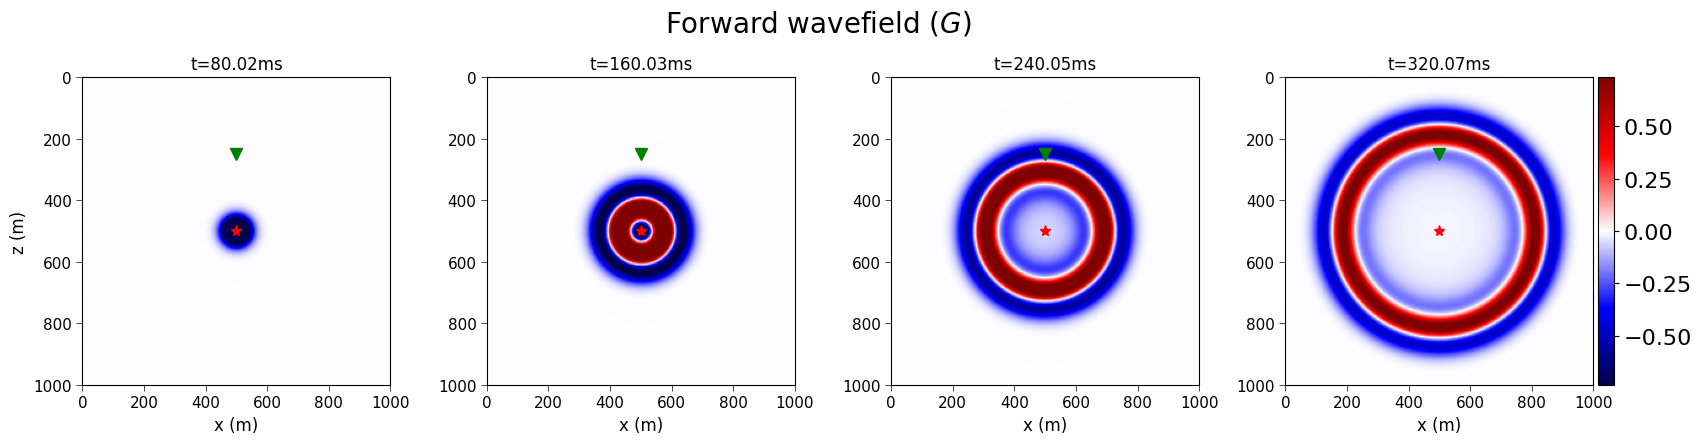

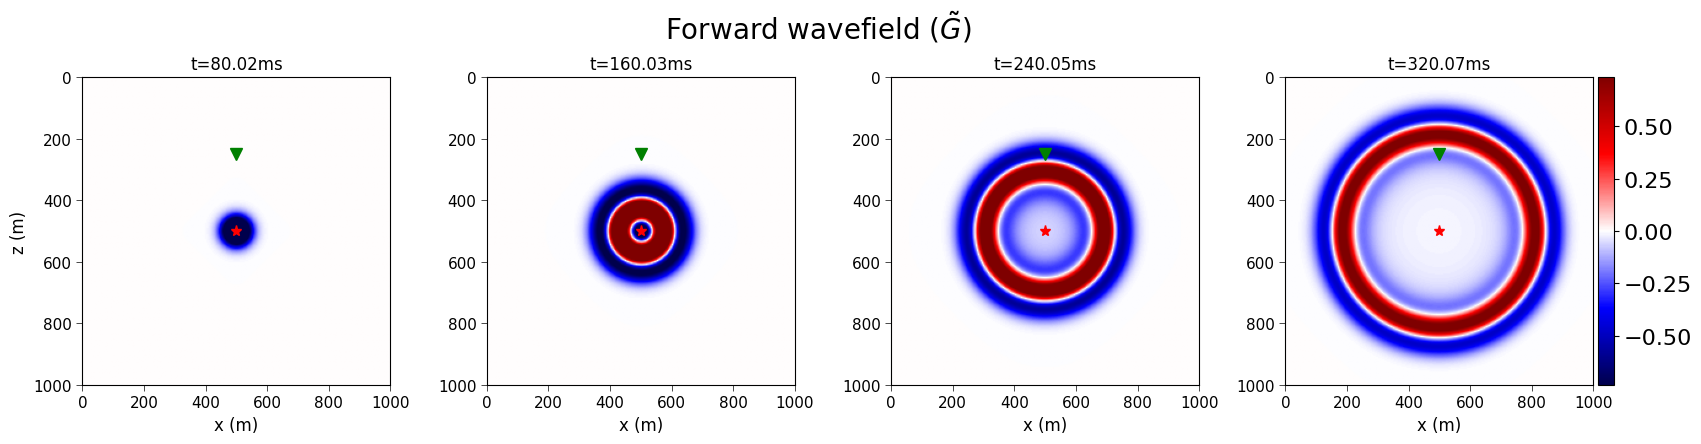

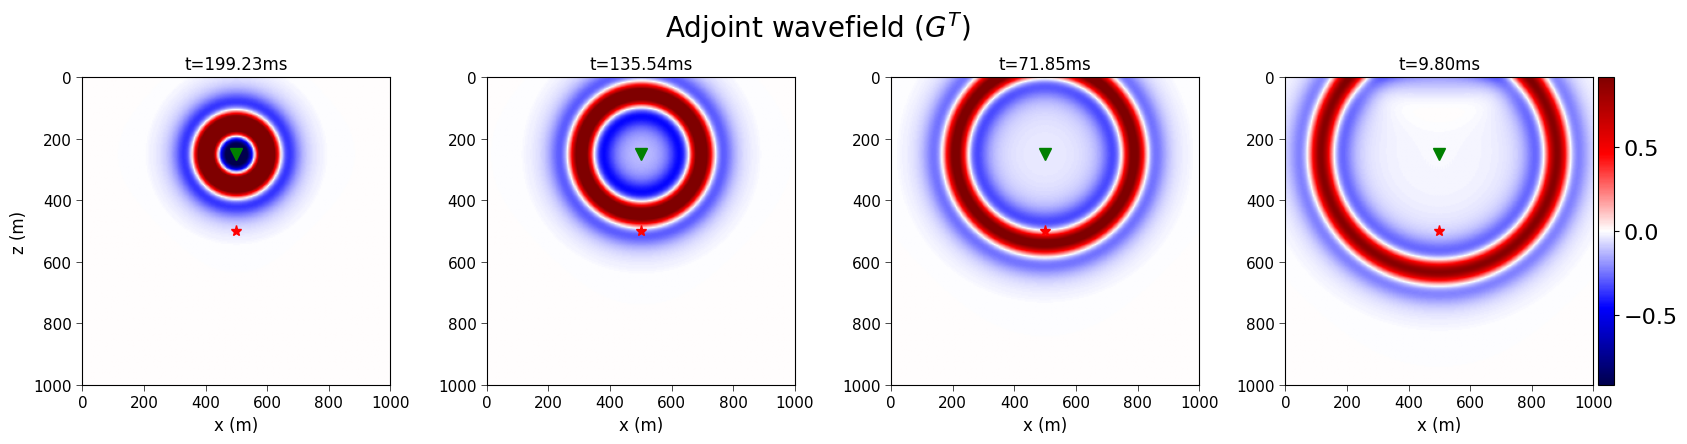

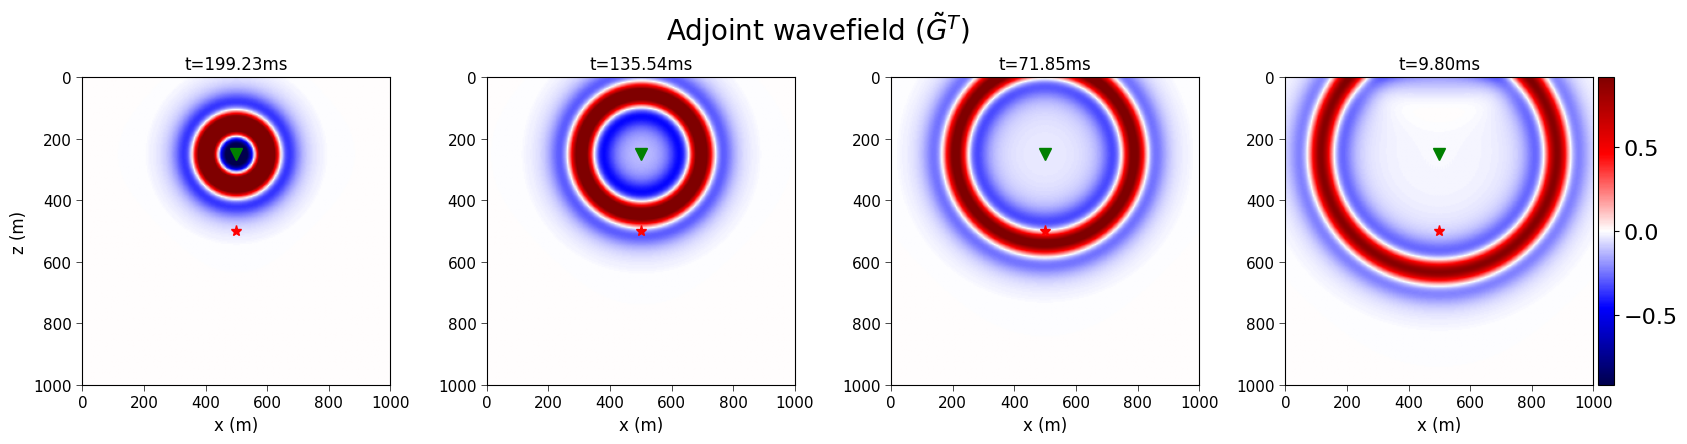

In [33]:
plot_wavefield(u_original, geometry.time_axis, src_pos2, model, 
               'Forward wavefield ($G$)', t0=80.0, tn=320, 
               rec_pos=rec2_original.coordinates.data[0]).savefig('forward-field-vr.png')
plot_wavefield(u_acoustic, geometry.time_axis, src_pos2, model, 
               'Forward wavefield ($\\tilde{G}$)', t0=80.0, tn=320, 
               rec_pos=rec2_original.coordinates.data[0]).savefig('forward-field-classic')
# plot_wavefield(v_original, aux_time_axis, rec2_original.coordinates.data[0], model, 
#                'Adjoint wavefield ($G^T$)', reverse_time=True, t0=80.0, tn=200)
# plot_wavefield(v_acoustic, aux_time_axis, rec2_acoustic.coordinates.data[0], model, 
#                'Adjoint wavefield ($\\tilde{G}^T$)', reverse_time=True, t0=80.0, tn=200)
plot_wavefield(v_original, geometry.time_axis, src_pos2, model, 
               'Adjoint wavefield ($G^T$)', reverse_time=True, t0=10.0, tn=200, 
               rec_pos=rec2_original.coordinates.data[0]).savefig('backward-field-vr.png')
plot_wavefield(v_acoustic, geometry.time_axis, src_pos2, model, 
               'Adjoint wavefield ($\\tilde{G}^T$)', reverse_time=True, t0=10.0, tn=200, 
               rec_pos=rec2_original.coordinates.data[0]).savefig('backward-field-classic.png')

In [34]:
def plot_trace(recs, labels, tr_idx, geometry, title='', start_idx = 0):
    t_axis = geometry.time_axis.time_values

    for i, rec in enumerate(recs):
        plt.plot(rec[start_idx:, tr_idx], t_axis[start_idx:], label=labels[i])

        plt.legend(fontsize='small')
        plt.title(title)
        plt.xlabel('Amplitude')
        plt.ylabel('Time (ms)')

        plt.grid()
    plt.gca().invert_yaxis()

    plt.show()

In [35]:
RMS_f = RMS(rec_acoustic.data - rec_original.data)

In [36]:
RMS_t = RMS(line_srca_acoustic.data - line_srca_original.data)

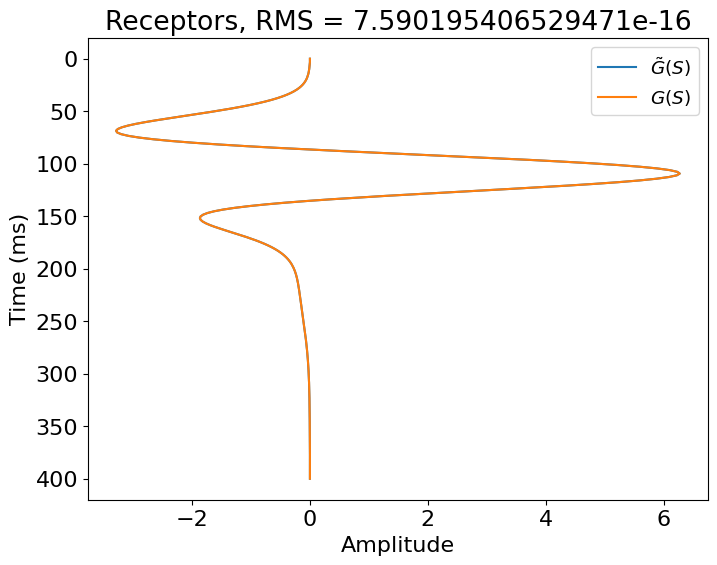

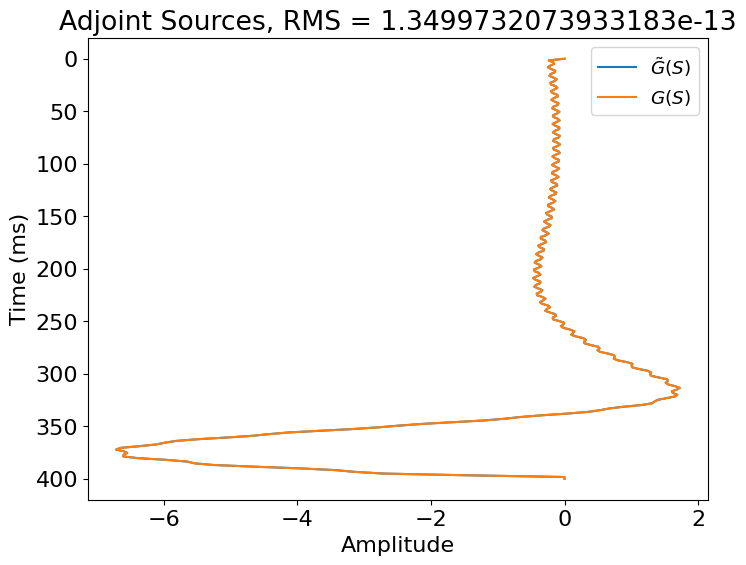

In [37]:
tr_idx = rec_original.data.shape[1]//2
start_idx = 0
# start_idx = int(100/geometry.dt)

plot_trace(recs, names, tr_idx, geometry, f'Receptors, RMS = {RMS_f}', start_idx=start_idx)
plot_trace(srcas, names, 0, geometry, f'Adjoint Sources, RMS = {RMS_t}', start_idx=start_idx)

In [38]:
def plot_seismograms_and_midtrace(rec1, rec2, name1, name2, model, t0, tn, colorbar=True):
    fig, axes = plt.subplots(1, 3, figsize=(6*3, 6))
    
    # scale = np.max(rec) / 10.
    extent = [model.origin[0], model.origin[0] + model.domain_size[0], tn, t0]

    scale = np.max(rec1)
    plot1 = axes[0].imshow(10*rec1, vmin=-scale, vmax=scale, cmap=cm.gray, extent=extent)
    axes[0].set_title(name1, fontsize=20)
    axes[0].set_xlabel('X position (m)', fontsize=20)
    axes[0].set_ylabel('Time (ms)', fontsize=20)
    axes[0].plot([500, 500], [0, 1000], color='red', ls='dashed')

    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(plot1, cax=cax)
    
    scale = np.max(rec1)
    plot2 = axes[1].imshow(10*rec2, vmin=-scale, vmax=scale, cmap=cm.gray, extent=extent)
    axes[1].set_title(name2, fontsize=20)
    axes[1].set_xlabel('X position (m)', fontsize=20)
    # axes[0].set_ylabel('Time (ms)', fontsize=20)
    axes[1].plot([500, 500], [0, 1000], color='blue', ls='dashed')

    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(plot2, cax=cax)

    t_axis = geometry.time_axis.time_values
    tr_idx = rec1.shape[1]//2
    axes[2].plot(rec1[:, tr_idx], t_axis, label=name1, color='red')
    axes[2].plot(rec2[:, tr_idx], t_axis, label=name2, ls='dashed', dashes=(5,5), color='blue')

    axes[2].legend(fontsize='small')
    axes[2].set_title('Receptor at x=500m', fontsize=20)
    axes[2].set_xlabel('Amplitude', fontsize=20)
    # axes[2].set_ylabel('Time (ms)', fontsize=20)

    # axes[2].grid()
    axes[2].invert_yaxis()
    
    # Create aligned colorbar on the right
    # if colorbar and i == len(recs) - 1:

    plt.tight_layout()
    plt.show()

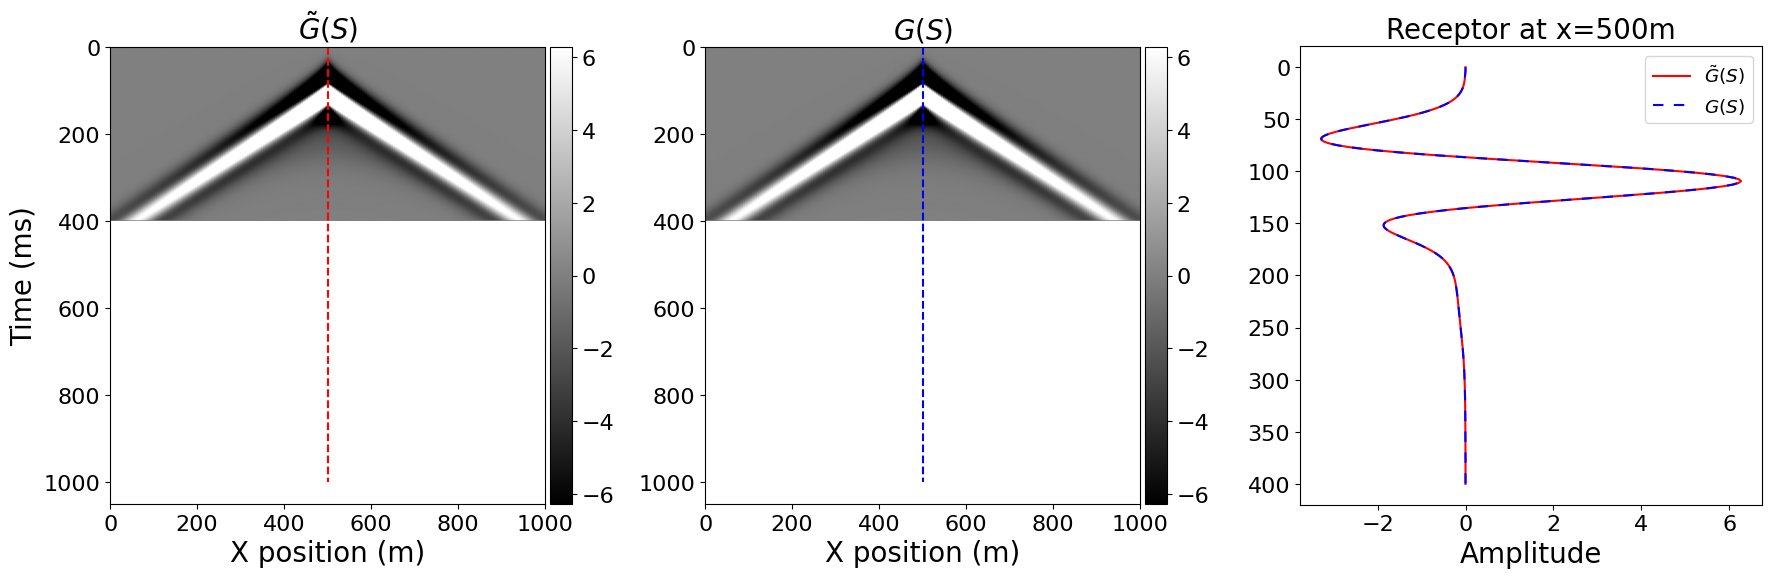

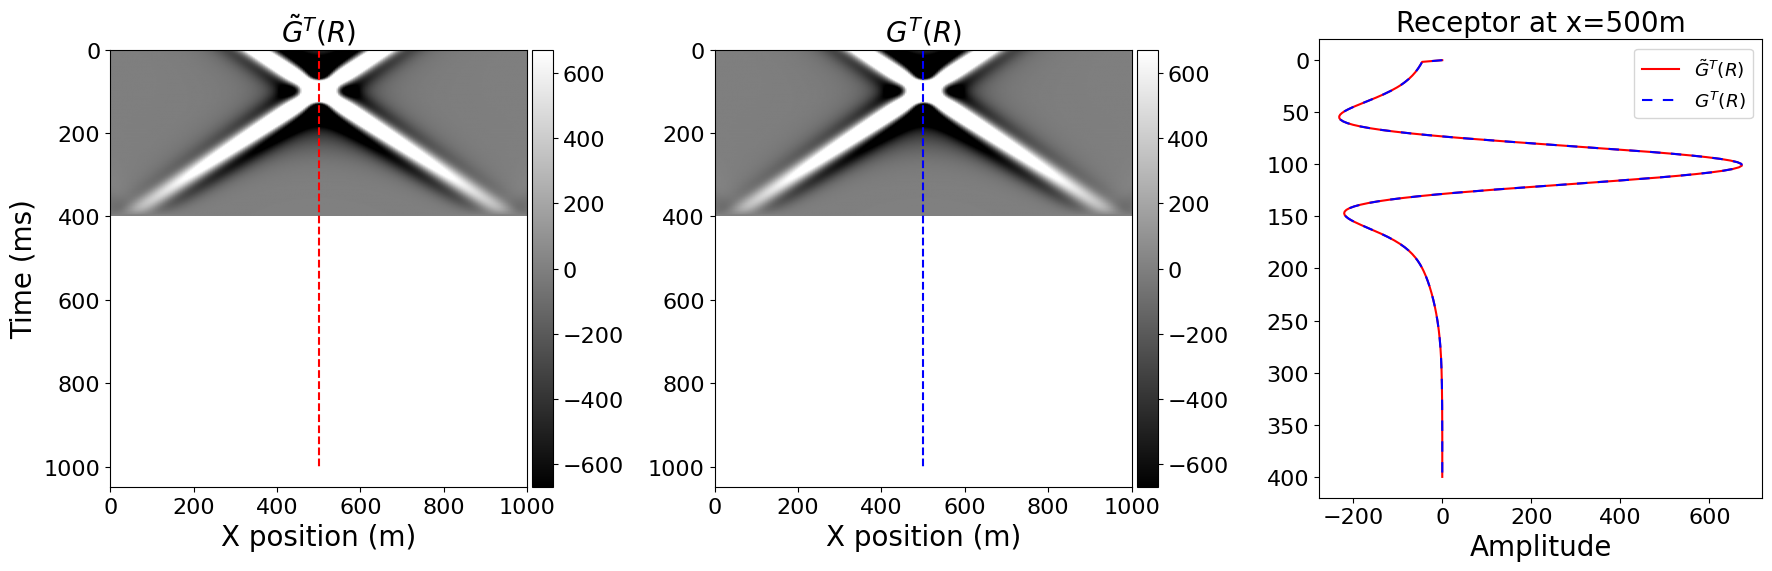

In [39]:
plot_seismograms_and_midtrace(
    rec_acoustic.data, rec_original.data, 
    '$\\tilde{G}(S)$', '$G(S)$', model,
    0, tn
)

plot_seismograms_and_midtrace(
    line_srca_acoustic.data, line_srca_original.data, 
    '$\\tilde{G}^T(R)$', '$G^T(R)$', model,
    0, tn
)

## Adjoint Test

In [40]:
if model.dtype == np.float64:
    eps = 1e-11
elif model.dtype == np.float32:
    eps = 1e-6

In [41]:
term1 = norm(rec_original) ** 2 # <Ax, y>
term2 = srca_original.data.T @ src_original.data # <x, A^Ty>
# term1 = norm(rec_acoustic) ** 2 # <Ax, y>
# term2 = srca_acoustic.data.T @ src_acoustic.data # <x, A^Ty>

print('<x, A*y>: %f, <Ax,y>: %f, difference: %4.4e, ratio: %f'
      % (term1, term2, (term1 - term2)/term1, term1/term2))

assert np.isclose((term1 - term2)/term1, 0., atol=eps)

<x, A*y>: 11413.832147, <Ax,y>: 11413.832147, difference: -9.5620e-16, ratio: 1.000000


/tmp/ipykernel_5450/3218376122.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('<x, A*y>: %f, <Ax,y>: %f, difference: %4.4e, ratio: %f'


In [42]:
np.abs(term1 - term2), np.abs((term1 - term2)/term1)

(Data([[1.09139364e-11]]), Data([[9.56202639e-16]]))

In [43]:
def latex_print(symbol):
    return Latex(f'$${latex(symbol)}$$'.replace('frac', 'dfrac'))